**실습1 - 문서 요약**
 1. 문서 업로드 (PDF or 텍스트)
 2. 문서 로드 & chunk 분할
 3. 벡터스토어 생성(Chroma)
 4. Retriever + LLM 생성

In [ ]:
# Chroma.from_documents : 임베딩 + 저장
# vectordb.as_retriever() : 검색 함수 제공
# RetrievalQA : 검색 + 프롬프트 생성 + LLM 호출

In [ ]:
# 필요한 라이브러리 설치
# !pip install langchain langchain-community langchain-openai chromadb pypdf


In [ ]:
!pip install langchain langchain-community langchain-openai
   # RAG 파이프라인을 구성하는 데 필요한 문서 로더, 텍스트 스플리터, 체인, 벡터 스토어 래퍼 등을 제공.
!pip install chromadb
   # 로컬 용 벡터 데이터베이스 (임베딩 저장 & 검색)
!pip install faiss-cpu
!pip install pypdf


In [ ]:
import os
OPENAI_API_KEY = "...."
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY


In [ ]:
### 문서 업로드 (PDF or 텍스트)

from google.colab import files
uploaded = files.upload()


Saving vit.paper.2010.11929v2.pdf to vit.paper.2010.11929v2 (1).pdf


In [ ]:
### 문서 로드 & chunk 분할

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = PyPDFLoader("vit.paper.2010.11929v2.pdf")  # <--- 업로드한 파일명으로 변경...
   # PDF 파일을 읽어서 LangChain의 Document 객체 리스트로 바꿔주는 클래스.
docs = loader.load()
   # PDF를 읽어 Document 리스트 저장

# 긴 텍스트를 잘게 쪼개서 검색 단위 만듦
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=100
      # 한 chunk의 최대 길이 : 500 (문자 수 기준)
      # 너무 길면 LLM 컨텍스트를 많이 차지, 너무 짧으면 문맥이 끊겨 답변 품질 하락.

      # chunk_overlap=100 : 앞 chunk의 마지막 100자와 다음 chunk의 처음 100자가 겹치게 잘라줌.
      # 앞/뒤 chunk가 서로 맥락을 공유하도록 하기 위해
)
chunks = splitter.split_documents(docs)
  # docs를 받아서 내부 텍스트를 합친 뒤,
  # 설정한 chunk_size / overlap에 맞춰 여러 개의 작은 chunks(Document)로 나눔.



In [ ]:
len(docs)  # 페이지 수

22

In [ ]:
chunks[0].page_content[:200]  # 첫 chunk의 앞 200자 확인


'Published as a conference paper at ICLR 2021\nAN IMAGE IS WORTH 16X16 W ORDS :\nTRANSFORMERS FOR IMAGE RECOGNITION AT SCALE\nAlexey Dosovitskiy∗,†, Lucas Beyer∗, Alexander Kolesnikov∗, Dirk Weissenborn∗,'

In [ ]:
chunks[0].metadata            # chunk metadata (document 정보 확인)

{'producer': 'pdfTeX-1.40.21',
 'creator': 'LaTeX with hyperref',
 'creationdate': '2021-06-04T00:19:58+00:00',
 'author': '',
 'keywords': '',
 'moddate': '2021-06-04T00:19:58+00:00',
 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2',
 'subject': '',
 'title': '',
 'trapped': '/False',
 'source': 'vit.paper.2010.11929v2.pdf',
 'total_pages': 22,
 'page': 0,
 'page_label': '1'}

In [ ]:
### 벡터 DB 생성(Chroma)

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings # 텍스트를 OpenAI 임베딩 모델(text-embedding-3-small 등)로 벡터화
                                                  # 각 chunk의 텍스트를 고차원 벡터로 변환

emb = OpenAIEmbeddings()
vectordb = Chroma.from_documents(chunks, emb)
   # chunks 리스트를 순회 -> 각 chunk.page_content를 emb로 임베딩 생성
   #   -> 생성된 벡터 + 원본 문서(Document)를 Chroma DB(로컬 폴더)에 저장


/tmp/ipython-input-2029611082.py:7: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  emb = OpenAIEmbeddings()


In [ ]:
### Retriever + LLM 생성

from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectordb.as_retriever(),
        # 벡터 스토어를 retriever 인터페이스로 변환.
    chain_type="stuff"
        # 가져온 Document들을 그냥 한 덩어리로(stuff) 붙여서 LLM 프롬프트에 넣음 <-- 가장 단순한 방식.
)

### "stuff" 방식으로 생성한  prompt 예시
# 다음은 참고할 컨텍스트입니다:
# {context}  <--- retriever가 가져온 chunks
# 위 컨텍스트를 바탕으로 다음 질문에 답변해 주세요:
# {question} <-- 사용자의 질문

### langchain
# 1. 검색 ... 임베딩 -> 코사인 유사도
# 2. 컨텍스트를 프롬프트에 포함
# 3. GPT에 질의
# <---- LangChain wrapper 역활... 위  process를 자동으로 처리


/tmp/ipython-input-3019252939.py:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [ ]:
### 질문하기

query = "이 문서의 핵심 내용을 요약해줘."
answer = qa.run(query)
answer

### qa.run
# retriever.get_relevant_documents(query) 실행
#  → vectordb에서 query와 유사한 chunk 가져옴 (k개)
# 가져온 chunk들을 합쳐서 context 문자열 생성
# LLM 프롬프트에 {context}, {question}를 입력 -> llm 호출

'이 문서는 이미지 인식에서 변환기(Transformers)의 사용에 대해 다루고 있습니다. 주요 내용은 ViT-H/14 및 ViT-L/16과 같은 대형 모델을 기존의 CNN과 비교하고, 이 모델들이 어떻게 성능을 향상시키는지를 설명합니다. 또한, 주의(attention) 메커니즘과 다중 헤드 자기 주의(multihead self-attention) 개념을 소개하며, 이를 통해 입력 시퀀스의 요소 간의 관계를 효과적으로 학습할 수 있음을 강조합니다. 마지막으로, 이 연구는 이미지 인식 분야에서의 최신 기술 동향과 기여를 다루고 있습니다.'

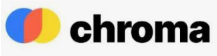

ChromaDB : 로컬에서 동작하는 벡터 데이터베이스

In [ ]:
# Chroma in LangChain
# 텍스트 → 임베딩 벡터로 변환, 벡터 + 원본 문서 + 메타데이터 저장,
# 문서 검색, 질문 벡터와의 유사도를 기준으로...

In [ ]:
# LangChain의 Chroma 래퍼 내부에 실제 chroma collection이 있습니다.
collection = vectordb._collection

print("문서 개수:", collection.count()) ##  chunk 갯수
   # chunk들을 벡터로 변환 -> 각 chunk마다 벡터 + metadata + text 정보 관리


문서 개수: 180


In [ ]:
### 저장된 문서/메타데이터/임베딩 확인

res = collection.get(
    limit=3,  # 앞 3개만 보기
    include=["documents", "metadatas", "embeddings"]
)

print(res.keys())   # dict의 키들: ids, embeddings, documents, metadatas
print("ids:", res["ids"])

for i in range(len(res["ids"])):
    print(f"\n=== {i}번째 ===")
    print("id:", res["ids"][i])
    print("document:", res["documents"][i][:200], "...")
    print("metadata:", res["metadatas"][i])
    print("embedding dim:", len(res["embeddings"][i]))


dict_keys(['ids', 'embeddings', 'documents', 'uris', 'included', 'data', 'metadatas'])
ids: ['a365f801-af75-4288-8f1a-1edc6295a2c8', '326d9a4e-b009-4582-9985-accfaabc8d3a', 'f17be90c-fe9f-4ade-9006-129d879149b9']

=== 0번째 ===
id: a365f801-af75-4288-8f1a-1edc6295a2c8
document: Published as a conference paper at ICLR 2021
AN IMAGE IS WORTH 16X16 W ORDS :
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE
Alexey Dosovitskiy∗,†, Lucas Beyer∗, Alexander Kolesnikov∗, Dirk Weissenborn∗, ...
metadata: {'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2', 'title': '', 'producer': 'pdfTeX-1.40.21', 'keywords': '', 'subject': '', 'creator': 'LaTeX with hyperref', 'author': '', 'source': 'vit.paper.2010.11929v2.pdf', 'page': 0, 'creationdate': '2021-06-04T00:19:58+00:00', 'page_label': '1', 'trapped': '/False', 'moddate': '2021-06-04T00:19:58+00:00', 'total_pages': 22}
embedding dim: 1536

=== 1번째 ===
id: 326d9a4e-b009-4582-9985-accfaabc8d3a
document

In [ ]:
### similarity search 결과 확인

query = "이 문서의 핵심 내용은 무엇인가?"
docs = vectordb.similarity_search(query, k=3)

for d in docs:
    print(d.page_content[:200], "...")
    print(d.metadata)
    print("-" * 60)


Published as a conference paper at ICLR 2021
AN IMAGE IS WORTH 16X16 W ORDS :
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE
Alexey Dosovitskiy∗,†, Lucas Beyer∗, Alexander Kolesnikov∗, Dirk Weissenborn∗, ...
{'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2', 'page': 0, 'keywords': '', 'title': '', 'trapped': '/False', 'creator': 'LaTeX with hyperref', 'total_pages': 22, 'page_label': '1', 'producer': 'pdfTeX-1.40.21', 'creationdate': '2021-06-04T00:19:58+00:00', 'moddate': '2021-06-04T00:19:58+00:00', 'author': '', 'subject': '', 'source': 'vit.paper.2010.11929v2.pdf'}
------------------------------------------------------------
transformers. arXiv, 2019.
Jean-Baptiste Cordonnier, Andreas Loukas, and Martin Jaggi. On the relationship between self-
attention and convolutional layers. In ICLR, 2020.
J. Deng, W. Dong, R. Socher, ...
{'creator': 'LaTeX with hyperref', 'subject': '', 'page_label': '10', 'producer': 'pdfTeX-1.40.21', 'mo

**실습2 - FAQ**
 1. FAQ 문서 준비
 2. 문서(FAQ) OpenAI 임베딩(벡터)로 변환, 저장
 3. 질문 임베딩
 4. 질문과 유사한 FAQ 검색 (코사인 유사도)
 5. 검색된 FAQ를 프롬프트에 포함하여 LLM에 전달 -> LLM 답변 생성


In [ ]:
import os
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
client = OpenAI()


In [ ]:
### 내 문서(지식) 예제
### 학습 서비스 회사 FAQ
### 실제 RAG 예시 PDF → chunk → 벡터 DB

docs = [
    {
        "id": 1,
        "title": "환불 규정",
        "text": "우리 회사의 유료 구독은 결제 후 7일 이내에는 전액 환불이 가능하고, 그 이후에는 사용 일수에 따라 부분 환불이 가능합니다."
    },
    {
        "id": 2,
        "title": "AI 튜터 기능",
        "text": "AI 튜터는 학습자의 레벨 테스트 결과를 기반으로 맞춤형 영어 회화 연습 문제를 제공합니다."
    },
    {
        "id": 3,
        "title": "데이터 보관 정책",
        "text": "학습 기록과 채팅 데이터는 서비스 품질 향상을 위해 최대 3년간 보관되며, 이용자가 요청할 경우 언제든지 삭제할 수 있습니다."
    },
    {
        "id": 4,
        "title": "수강 연장",
        "text": "수강 기간은 마이페이지에서 1개월 단위로 연장할 수 있으며, 연장 시 기존 수강 기록은 그대로 유지됩니다."
    }
]


In [ ]:
### 각 문서를 임베딩으로 변환 -> 벡터 저장

import numpy as np

# 1) 문서 텍스트 리스트
doc_texts = [d["text"] for d in docs]

# 2) 임베딩 변환
emb_res = client.embeddings.create(
    model="text-embedding-3-small",
    input=doc_texts
) # FAQ 4개 → 벡터 4개


# 3) numpy 배열로 변환
doc_embeddings = np.array([item.embedding for item in emb_res.data])
doc_embeddings.shape


(4, 1536)

In [ ]:
### 질문 → 가장 관련 있는 문서들 검색 (간단 코사인 유사도)

from numpy.linalg import norm

def embed_text(text: str):  # 사용자 질문을 벡터로 변환
    res = client.embeddings.create(
        model="text-embedding-3-small",
        input=[text]
    )
    return np.array(res.data[0].embedding)


def search_docs(query: str, k: int = 3):  # 관련 있는 FAQ 검색 함수
    """
    query를 임베딩하고, 모든 문서와 코사인 유사도를 계산해서
    상위 k개 문서를 반환
    """
    q_emb = embed_text(query)  # 질문을 임베딩 벡터로 변환
    sim_scores = (doc_embeddings @ q_emb) / (norm(doc_embeddings, axis=1) * norm(q_emb) + 1e-10)
           # 코사인 유사도 계산

    # 유사도 순으로 정렬
    top_idx = np.argsort(sim_scores)[::-1][:k]

    results = []
    for idx in top_idx:
        results.append({
            "score": float(sim_scores[idx]),
            "doc": docs[idx]
        })
    return results

# 테스트
search_docs("환불 기간이 어떻게 되나요?", k=2)  # 가장 유사한 문서 K개 선택



[{'score': 0.3264114056920408,
  'doc': {'id': 1,
   'title': '환불 규정',
   'text': '우리 회사의 유료 구독은 결제 후 7일 이내에는 전액 환불이 가능하고, 그 이후에는 사용 일수에 따라 부분 환불이 가능합니다.'}},
 {'score': 0.283685318387456,
  'doc': {'id': 3,
   'title': '데이터 보관 정책',
   'text': '학습 기록과 채팅 데이터는 서비스 품질 향상을 위해 최대 3년간 보관되며, 이용자가 요청할 경우 언제든지 삭제할 수 있습니다.'}}]

In [ ]:
### RAG 방식으로 프롬프트 구성 + GPT 호출

def build_rag_prompt(query: str, retrieved_docs):
    """
    RAG 스타일 프롬프트 문자열을 만들어 주는 함수
    """
    context_blocks = []
    for item in retrieved_docs:
        d = item["doc"]
        block = f"제목: {d['title']}\n내용: {d['text']}"
        context_blocks.append(block)

    context_text = "\n\n---\n\n".join(context_blocks)

    user_message = f"""
아래는 우리 회사의 내부 문서에서 발췌한 내용입니다. 이 컨텍스트를 우선적으로 참고해서 사용자 질문에 답변해 주세요.

[컨텍스트 시작]
{context_text}
[컨텍스트 끝]

사용자 질문: {query}

답변 시:
- 컨텍스트에 있는 정보 위주로 설명하고
- 문서에 없는 내용은 추측하지 말고 "문서에 없는 내용입니다"라고 말해 주세요.
"""
    return user_message


def ask_with_rag(query: str):
    # 1) 관련 문서 검색
    retrieved = search_docs(query, k=3)

    # 2) 프롬프트 생성 (컨텍스트 + 질문)
    user_content = build_rag_prompt(query, retrieved)

    # 3) GPT 호출
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  # 또는 gpt-4.1, gpt-4o 등
        messages=[
            {
                "role": "system",
                "content": "너는 회사 내부 문서를 이용해서 고객 문의에 답변하는 헬프데스크 직원이야."
            },
            {
                "role": "user",
                "content": user_content
            }
        ]
    )
    return response.choices[0].message.content

# 예시 질문
print(ask_with_rag("이미 결제했는데, 환불은 언제까지 가능한가요?"))

########### RAG : 프롬프트에 지식(문서)을 넣어주는 기법


결제 후 7일 이내에는 전액 환불이 가능합니다. 7일이 지난 후에는 사용 일수에 따라 부분 환불이 가능하니 참고해 주세요. 추가적인 환불 조건에 대해서는 문서에 없는 내용입니다.


In [ ]:
# 예시 질문2
print(ask_with_rag("수강 연장 가능한가요?"))

네, 수강 기간은 마이페이지에서 1개월 단위로 연장할 수 있습니다. 연장 시 기존 수강 기록은 그대로 유지됩니다. 추가적인 사항은 문서에 없는 내용입니다.
